In [92]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
from nltk.corpus import stopwords


In [315]:

def load_sentences(domain='pool', data_type=['train', 'test', 'valid']):
    sents = None

    for dt in ['train', 'test', 'valid']:
        if dt not in data_type:
            continue
        
        dt_sents = pd.read_csv('./data/' + domain + '/' + dt + '/sentences.txt', sep='\n', header=None)
        if sents is None:
            sents = dt_sents
        else:
            sents = pd.concat([sents, dt_sents], axis=0)

    sents.columns = ['sentence']
    return sents



def cal_top_words(words, freqs, n=100, rare=False):
    words = np.array(words)
    freqs = np.array(freqs)


    if rare:
        top_n_words = words[freqs < n]
        top_n_freqs = freqs[freqs < n]
    else:
        top_n_words = words[freqs > n]
        top_n_freqs = freqs[freqs > n]

    top_word_freq = {w: top_n_freqs[i] for i,w in enumerate(top_n_freqs)}

    return top_word_freq, top_n_words, top_n_freqs



stop = stopwords.words('english')
def cal_word_freq(corpus):
    words = []
    for sent in corpus:
        for w in sent.split():
#             w_l = w.lower()
#             if w_l.strip() in stop or w_l in string.punctuation or w_l.isdigit() or w_l in ['\'s', 'said', "n't", '--'] or '0' in w_l:
#                 continue
            words.append(w)

    print('total words ', len(words))
    
    w_freq = nltk.FreqDist(words)

    return {w: q for w, q in w_freq.items()}, np.array(list(w_freq.keys())), np.array(list(w_freq.values()))


# Training data from all domains

In [316]:
sents_all_domain = load_sentences('pool', ['train', 'valid', 'test'])

sents_all_domain.shape


(112511, 1)

In [317]:
sents_all_domain.head()


,sentence
0,This is Hardball only on msnbc .
1,-LSB- -RSB-
2,That 's all for today .
3,It it the end comes when the insurgency clearl...
4,He called him I do n't use this phrase often s...


# Rare Words

sents with different scarcity of rare words (e.g. contains word <1% occurance freq)


In [348]:
word_counts, words, freqs = cal_word_freq(sents_all_domain['sentence'].tolist())

freqs_ratio = freqs / sum(freqs)


total words  2376914


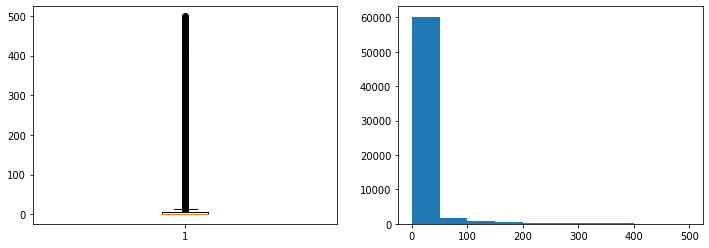

count    63837.000000
mean        13.076194
std         41.457864
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        499.000000
dtype: float64

In [373]:

rare_words = freqs[ (freqs < 200) & (freqs > 50) ]
rare_words = freqs[ (freqs < 500) ]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].boxplot(x=rare_words)
ax[1].hist(x=rare_words)
plt.show()o

pd.Series(rare_words).describe()


In [322]:
1.945910 * 1.5 + 1.945910

# 0.5, 0.75, 1.5IQR, max
# [0， 0.693147, 1.791759, 4.4793975, 8.546558]


4.864775

# Sentence Length

## All domains

In [231]:
sents_all_domain = load_sentences('pool', ['train', 'valid', 'test'])

sent_len_all_domain = pd.Series([ len( sent.split() ) for sent in sents_all_domain['sentence'] ])

sent_len_all_domain.shape


(112511,)

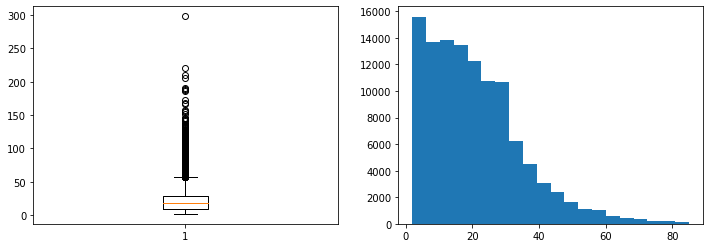

count    112511.000000
mean         21.126059
std          14.928275
min           2.000000
25%          10.000000
50%          18.000000
75%          29.000000
max         298.000000
dtype: float64

In [232]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].boxplot(x=sent_len_all_domain)
ax[1].hist(x=sent_len_all_domain[sent_len_all_domain<86], bins=20)
plt.show()

sent_len_all_domain.describe()


In [233]:
29 + 1.5* (29 - 10), 29 + 3 * (29 - 10), 

# [<5, [5, 30), [30, 58), [58, 86), >86 ]


(57.5, 86)

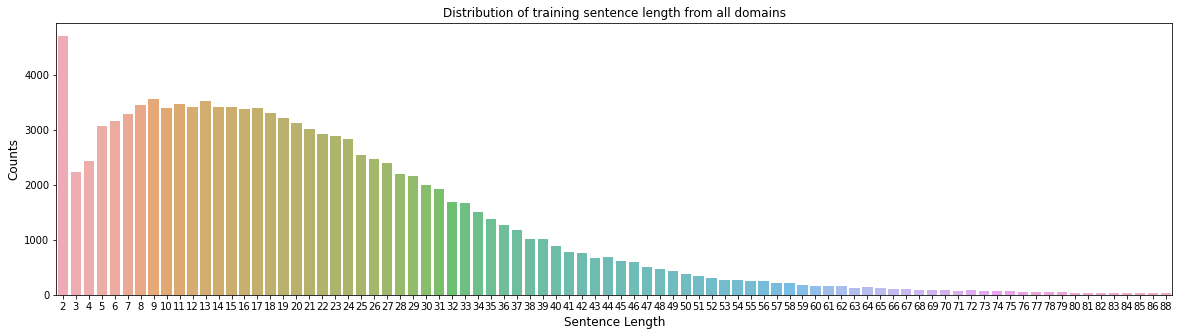

In [234]:
sent_len_counts = sent_len_all_domain.value_counts()
top_100_sent_len = sent_len_counts[:86]

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=top_100_sent_len.index, y=top_100_sent_len.values, alpha=0.8)
ax.set_title('Distribution of training sentence length from all domains')
ax.set_ylabel('Counts', fontsize=12)
ax.set_xlabel('Sentence Length', fontsize=12)
plt.show()


## Domain-Specific

In [272]:
sents_bc = load_sentences('bc', ['train', 'valid', 'test'])
sents_bn = load_sentences('bn', ['train', 'valid', 'test'])
sents_mz = load_sentences('mz', ['train', 'valid', 'test'])
sents_nw = load_sentences('nw', ['train', 'valid', 'test'])
sents_tc = load_sentences('tc', ['train', 'valid', 'test'])
sents_wb = load_sentences('wb', ['train', 'valid', 'test'])

sent_len_sents_bc = pd.Series([ len( sent.split() ) for sent in sents_bc['sentence'] ])
sent_len_sents_bn = pd.Series([ len( sent.split() ) for sent in sents_bn['sentence'] ])
sent_len_sents_mz = pd.Series([ len( sent.split() ) for sent in sents_mz['sentence'] ])
sent_len_sents_nw = pd.Series([ len( sent.split() ) for sent in sents_nw['sentence'] ])
sent_len_sents_tc = pd.Series([ len( sent.split() ) for sent in sents_tc['sentence'] ])
sent_len_sents_wb = pd.Series([ len( sent.split() ) for sent in sents_wb['sentence'] ])

sent_len_sents_bc.shape


(16162,)

[15.208699418388813,
 19.461144578313252,
 24.750636780438104,
 26.690857000498255,
 8.57938838358519,
 23.0728426636355]

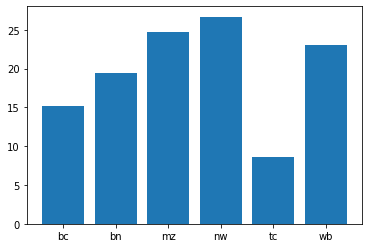

In [297]:
domains = ['bc', 'bn', 'mz', 'nw', 'tc', 'wb']

fig, ax = plt.subplots(figsize=(6, 4))
avg_words_per_domain = [ 
    np.mean(sent_len_sents_bc), np.mean(sent_len_sents_bn), 
    np.mean(sent_len_sents_mz), np.mean(sent_len_sents_nw),
    np.mean(sent_len_sents_tc), np.mean(sent_len_sents_wb)
]
ax.bar(x=domains, height=avg_words_per_domain)

avg_words_per_domain


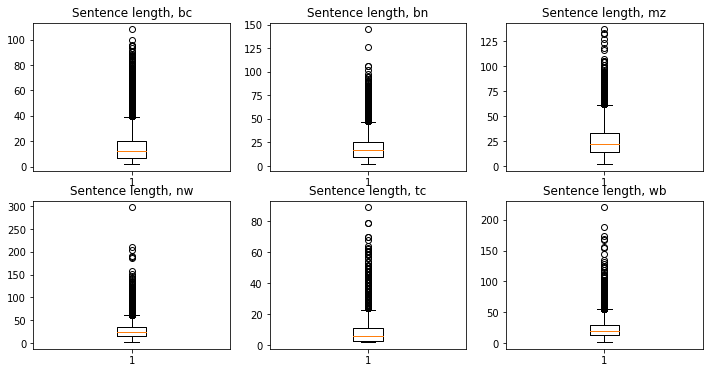

In [278]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

ax[0,0].boxplot(x=sent_len_sents_bc)
ax[0,0].set_title('Sentence length, bc')

ax[0,1].boxplot(x=sent_len_sents_bn)
ax[0,1].set_title('Sentence length, bn')

ax[0,2].boxplot(x=sent_len_sents_mz)
ax[0,2].set_title('Sentence length, mz')

ax[1,0].boxplot(x=sent_len_sents_nw)
ax[1,0].set_title('Sentence length, nw')

ax[1,1].boxplot(x=sent_len_sents_tc)
ax[1,1].set_title('Sentence length, tc')

ax[1,2].boxplot(x=sent_len_sents_wb)
ax[1,2].set_title('Sentence length, wb')

plt.show()

In [ ]:
ax[1].hist(x=sent_len_all_domain[sent_len_all_domain<86], bins=20)


sent_len_all_domain.describe()
